In [1]:
import os
import random
import sys

import time

import yaml

from pathlib import Path

from copy import deepcopy

import numpy as np
import math

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from torchvision.io import read_image, ImageReadMode
import torchvision

import albumentations as A
from albumentations.pytorch import ToTensorV2

from pytorch_model_summary import summary

from fLossFunctions import v8DetectionLoss
from fValidation import v8DetectionValidator

from collections import defaultdict
from tqdm import tqdm

import cv2
import matplotlib.pyplot as plt

import pandas as pd

from torch.ao.quantization import QuantStub, DeQuantStub

In [2]:
# mAP50 mAP50-95 MSEdepth

# Trained model
baseline = {'mAP50': 0.6859316583068573, 'mAP50-95': 0.3575120653828233, 'depth': 9.438}

conv1 = {'10':
         {'mAP50': 0.677429488428557, 'mAP50-95': 0.35104785331125543,
          'depth':9.516},
        '25':
         {'mAP50': 0.2587044575277193, 'mAP50-95': 0.11918162880110497,
          'depth':9.797},
        '50':
         {'mAP50': 0.04030479034231659, 'mAP50-95': 0.012536553737691036,
          'depth':10.761},         
        }

conv2 = {'10':
         {'mAP50': 0.6725524196527147, 'mAP50-95': 0.352695333208448,
          'depth':9.445},
        '25':
         {'mAP50': 0.4622880431070383, 'mAP50-95': 0.21188926223152427,
          'depth':9.320},
        '50':
         {'mAP50': 0.11016375354725226, 'mAP50-95': 0.0357040222828138,
          'depth':11.618},         
        }

conv3 = {'10':
         {'mAP50': 0.6595360344018575, 'mAP50-95': 0.3397372299626343,
          'depth':9.559},
        '25':
         {'mAP50': 0.6298801908880041, 'mAP50-95': 0.322367209403739,
          'depth':9.698},
        '50':
         {'mAP50': 0.417061653835184, 'mAP50-95': 0.19948462825256505,
          'depth':10.694},         
        }

conv4 = {'10':
         {'mAP50': 0.6822501716736099, 'mAP50-95': 0.35639710102947286,
          'depth':9.448},
        '25':
         {'mAP50': 0.6863283548850915, 'mAP50-95': 0.35897847051294896,
          'depth':9.563},
        '50':
         {'mAP50': 0.6585001302149285, 'mAP50-95': 0.35018719202107124,
          'depth':10.079},         
        }

conv5 = {'10':
         {'mAP50': 0.6859316583068573, 'mAP50-95': 0.3575120653828233,
          'depth':9.438},
        '25':
         {'mAP50': 0.6862439437849038, 'mAP50-95': 0.35802784941328797,
          'depth':9.438},
        '50':
         {'mAP50': 0.6885393163173565, 'mAP50-95': 0.3601976991188013,
          'depth':9.515},         
        }

conv6 = {'10':
         {'mAP50': 0.6857972082818439, 'mAP50-95': 0.3577243640193509,
          'depth':9.492},
        '25':
         {'mAP50': 0.6858310423108167, 'mAP50-95': 0.3576132879311403,
          'depth':9.484},
        '50':
         {'mAP50': 0.6866004216431126, 'mAP50-95': 0.3575157575947502,
          'depth':9.530},         
        }

conv7 = {'10':
         {'mAP50': 0.6859316150979766, 'mAP50-95': 0.35751232543933115,
          'depth':9.438},
        '25':
         {'mAP50': 0.68593791888219, 'mAP50-95': 0.3575260320295587,
          'depth':9.438},
        '50':
         {'mAP50': 0.6860441081805616, 'mAP50-95': 0.35762130752374166,
          'depth':9.440},         
        }

c2f1 = {'10':
         {'mAP50': 0.5892088533406692, 'mAP50-95': 0.29790438378554784,
          'depth':9.941},
        '25':
         {'mAP50': 0.10538732710688123, 'mAP50-95': 0.039914415140038045,
          'depth':16.092},
        '50':
         {'mAP50': 0.11074836297972418, 'mAP50-95': 0.04572301172332567,
          'depth':28.691},         
        }

c2f2 = {'10':
         {'mAP50': 0.6448941378459115, 'mAP50-95': 0.3352480070356788,
          'depth':9.377},
        '25':
         {'mAP50': 0.5532158163165796, 'mAP50-95': 0.2663029459448744,
          'depth':9.870},
        '50':
         {'mAP50': 0.33240382390214473, 'mAP50-95': 0.15182167230486254,
          'depth':11.033},         
        }

c2f3 = {'10':
         {'mAP50': 0.6867657358370429, 'mAP50-95': 0.3583397115593293,
          'depth':9.367},
        '25':
         {'mAP50': 0.6841380953742398, 'mAP50-95': 0.3573043609969228,
          'depth':9.375},
        '50':
         {'mAP50': 0.6484813173952187, 'mAP50-95': 0.3472873891175784,
          'depth':10.053},         
        }

c2f4 = {'10':
         {'mAP50': 0.685609098022111, 'mAP50-95': 0.357706502821078,
          'depth':9.437},
        '25':
         {'mAP50': 0.6732371155727589, 'mAP50-95': 0.354359630862613,
          'depth':9.700},
        '50':
         {'mAP50': 0.6074346486705312, 'mAP50-95': 0.32550032041145166,
          'depth':9.947},         
        }

c2f5 = {'10':
         {'mAP50': 0.6800879346812589, 'mAP50-95': 0.3559732795128925,
          'depth':9.388},
        '25':
         {'mAP50': 0.6675715619413229, 'mAP50-95': 0.3535964986960253,
          'depth':9.462},
        '50':
         {'mAP50': 0.5892581538807392, 'mAP50-95': 0.32185624491752335,
          'depth':9.484},         
        }

c2f6 = {'10':
         {'mAP50': 0.681031123011237, 'mAP50-95': 0.349307358812802,
          'depth':9.378},
        '25':
         {'mAP50': 0.5907847332488525, 'mAP50-95': 0.2669274659309292,
          'depth':9.902},
        '50':
         {'mAP50': 0.3025136542221415, 'mAP50-95': 0.10999007580608663,
          'depth':10.047},         
        }

c2f7 = {'10':
         {'mAP50': 0.6856695136241525, 'mAP50-95': 0.3575670423974222,
          'depth':9.565},
        '25':
         {'mAP50': 0.6866072025694588, 'mAP50-95': 0.35758025423725937,
          'depth':9.646},
        '50':
         {'mAP50': 0.686446491731695, 'mAP50-95': 0.3572986171143253,
          'depth':9.850},         
        }

c2f8 = {'10':
         {'mAP50': 0.6859310719791117, 'mAP50-95': 0.35751198070401363,
          'depth':9.438},
        '25':
         {'mAP50': 0.6859416987848366, 'mAP50-95': 0.3575171472601685,
          'depth':9.438},
        '50':
         {'mAP50': 0.6856379561628424, 'mAP50-95': 0.3575275764818625,
          'depth':9.437},         
        }

detect1 = {'10':
         {'mAP50': 0.6760016283964697, 'mAP50-95': 0.33869911304612416,
          'depth':9.453},
        '25':
         {'mAP50': 0.6610197458041824, 'mAP50-95': 0.32083748548581426,
          'depth':9.473},
        '50':
         {'mAP50': 0.5861480846116291, 'mAP50-95': 0.29526547884131676,
          'depth':9.361},         
        }

detect2 = {'10':
         {'mAP50': 0.6857643101576455, 'mAP50-95': 0.357504789855906,
          'depth':9.437},
        '25':
         {'mAP50': 0.6844102397167227, 'mAP50-95': 0.3570787550657405,
          'depth':9.431},
        '50':
         {'mAP50': 0.6842331792846142, 'mAP50-95': 0.35662603808715604,
          'depth':9.709},         
        }

detect3 = {'10':
         {'mAP50': 0.6859660787072583, 'mAP50-95': 0.35763616273661125,
          'depth':9.437},
        '25':
         {'mAP50': 0.6859859192598545, 'mAP50-95': 0.35766903892716845,
          'depth':9.437},
        '50':
         {'mAP50': 0.6851938125699771, 'mAP50-95': 0.3573902051759418,
          'depth':9.434},         
        }

In [3]:
conv_modules = [conv1, conv2, conv3, conv4, conv5, conv6, conv7]
c2f_modules = [c2f1, c2f2, c2f3, c2f4, c2f5, c2f6, c2f7, c2f8]
detect_modules = [detect1, detect2, detect3]

## Conv modules

In [4]:
conv_labels = ['Conv1','Conv2','Conv3','Conv4','Conv5','Conv6','Conv7']

conv_map50_diff_10 = []
conv_map50_diff_25 = []
conv_map50_diff_50 = []

conv_map5095_diff_10 = []
conv_map5095_diff_25 = []
conv_map5095_diff_50 = []

conv_mseDepth_diff_10 = []
conv_mseDepth_diff_25 = []
conv_mseDepth_diff_50 = []

for conv in conv_modules:
    
    # mAP50
    diff = baseline['mAP50'] - conv['10']['mAP50']
    conv_map50_diff_10.append(diff*100)
    
    diff = baseline['mAP50'] - conv['25']['mAP50']
    conv_map50_diff_25.append(diff*100)
    
    diff = baseline['mAP50'] - conv['50']['mAP50']
    conv_map50_diff_50.append(diff*100)

    
    # mAP50-95
    diff = baseline['mAP50-95'] - conv['10']['mAP50-95']
    conv_map5095_diff_10.append(diff*100)
    
    diff = baseline['mAP50-95'] - conv['25']['mAP50-95']
    conv_map5095_diff_25.append(diff*100)
    
    diff = baseline['mAP50-95'] - conv['50']['mAP50-95']
    conv_map5095_diff_50.append(diff*100)
    
    # depth
    diff = baseline['depth'] - conv['10']['depth']
    conv_mseDepth_diff_10.append(-diff)
    
    diff = baseline['depth'] - conv['25']['depth']
    conv_mseDepth_diff_25.append(-diff)
    
    diff = baseline['depth'] - conv['50']['depth']
    conv_mseDepth_diff_50.append(-diff)    
    

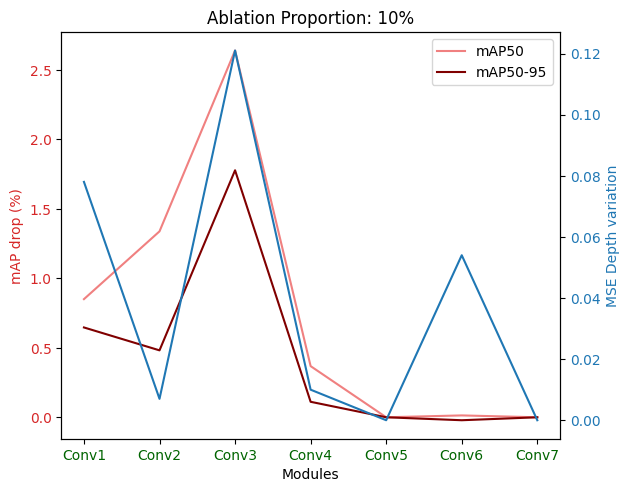

In [5]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Modules')
ax1.set_ylabel('mAP drop (%)', color=color)
ax1.plot(conv_map50_diff_10, color='lightcoral')
ax1.plot(conv_map5095_diff_10, color='maroon')
ax1.legend(['mAP50', 'mAP50-95'], loc='upper right')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', labelcolor='darkgreen')

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('MSE Depth variation', color=color) 
ax2.plot(conv_mseDepth_diff_10, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Ablation Proportion: 10%')
plt.xticks([0, 1, 2, 3, 4, 5, 6], conv_labels)
plt.savefig('conv_10.png', bbox_inches='tight')
plt.show()

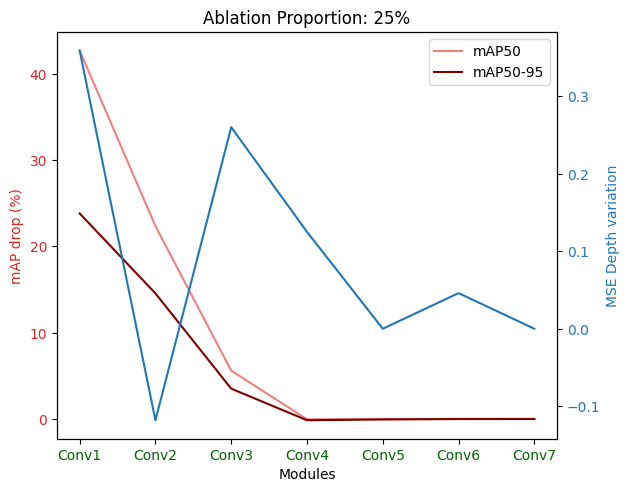

In [6]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Modules')
ax1.set_ylabel('mAP drop (%)', color=color)
ax1.plot(conv_map50_diff_25, color='lightcoral')
ax1.plot(conv_map5095_diff_25, color='maroon')
ax1.legend(['mAP50', 'mAP50-95'], loc='upper right')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', labelcolor='darkgreen')

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('MSE Depth variation', color=color) 
ax2.plot(conv_mseDepth_diff_25, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Ablation Proportion: 25%')
plt.xticks([0, 1, 2, 3, 4, 5, 6], conv_labels)
plt.savefig('conv_25.png', bbox_inches='tight')
plt.show()

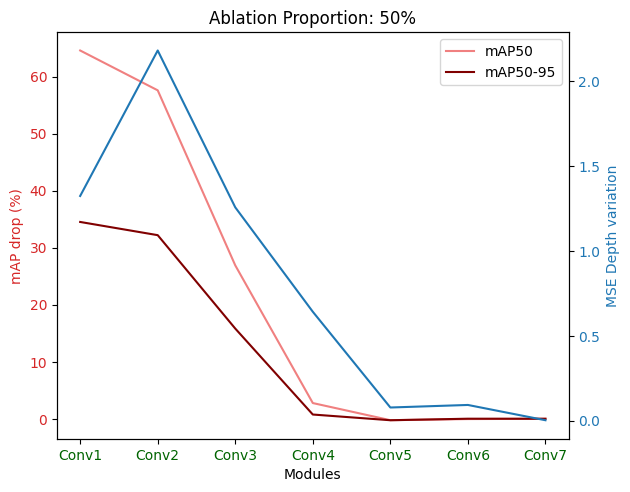

In [7]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Modules')
ax1.set_ylabel('mAP drop (%)', color=color)
ax1.plot(conv_map50_diff_50, color='lightcoral')
ax1.plot(conv_map5095_diff_50, color='maroon')
ax1.legend(['mAP50', 'mAP50-95'], loc='upper right')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', labelcolor='darkgreen')

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('MSE Depth variation', color=color) 
ax2.plot(conv_mseDepth_diff_50, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Ablation Proportion: 50%')
plt.xticks([0, 1, 2, 3, 4, 5, 6], conv_labels)
plt.savefig('conv_50.png', bbox_inches='tight')
plt.show()

### C2f modules

In [8]:
c2f_labels = ['C2f1','C2f2','C2f3','C2f4','C2f5','C2f6','C2f7', 'C2f8']

c2f_map50_diff_10 = []
c2f_map50_diff_25 = []
c2f_map50_diff_50 = []

c2f_map5095_diff_10 = []
c2f_map5095_diff_25 = []
c2f_map5095_diff_50 = []

c2f_mseDepth_diff_10 = []
c2f_mseDepth_diff_25 = []
c2f_mseDepth_diff_50 = []

for c2f in c2f_modules:
    
    # mAP50
    diff = baseline['mAP50'] - c2f['10']['mAP50']
    c2f_map50_diff_10.append(diff*100)
    
    diff = baseline['mAP50'] - c2f['25']['mAP50']
    c2f_map50_diff_25.append(diff*100)
    
    diff = baseline['mAP50'] - c2f['50']['mAP50']
    c2f_map50_diff_50.append(diff*100)

    
    # mAP50-95
    diff = baseline['mAP50-95'] - c2f['10']['mAP50-95']
    c2f_map5095_diff_10.append(diff*100)
    
    diff = baseline['mAP50-95'] - c2f['25']['mAP50-95']
    c2f_map5095_diff_25.append(diff*100)
    
    diff = baseline['mAP50-95'] - c2f['50']['mAP50-95']
    c2f_map5095_diff_50.append(diff*100)
    
    # depth
    diff = baseline['depth'] - c2f['10']['depth']
    c2f_mseDepth_diff_10.append(-diff)
    
    diff = baseline['depth'] - c2f['25']['depth']
    c2f_mseDepth_diff_25.append(-diff)
    
    diff = baseline['depth'] - c2f['50']['depth']
    c2f_mseDepth_diff_50.append(-diff)

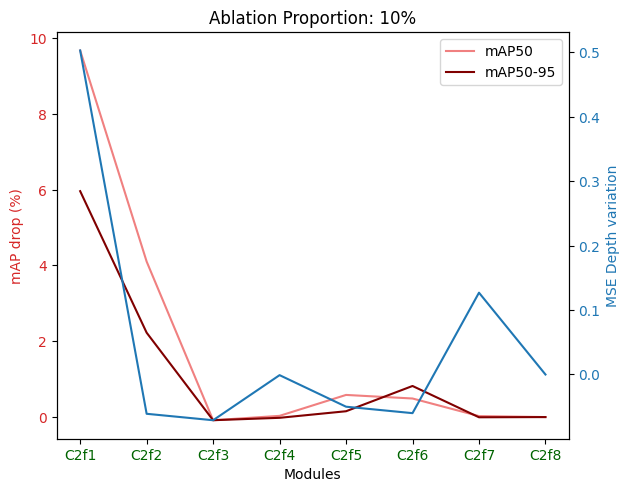

In [9]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Modules')
ax1.set_ylabel('mAP drop (%)', color=color)
ax1.plot(c2f_map50_diff_10, color='lightcoral')
ax1.plot(c2f_map5095_diff_10, color='maroon')
ax1.legend(['mAP50', 'mAP50-95'], loc='upper right')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', labelcolor='darkgreen')

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('MSE Depth variation', color=color) 
ax2.plot(c2f_mseDepth_diff_10, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Ablation Proportion: 10%')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], c2f_labels)
plt.savefig('cf2_10.png', bbox_inches='tight')
plt.show()

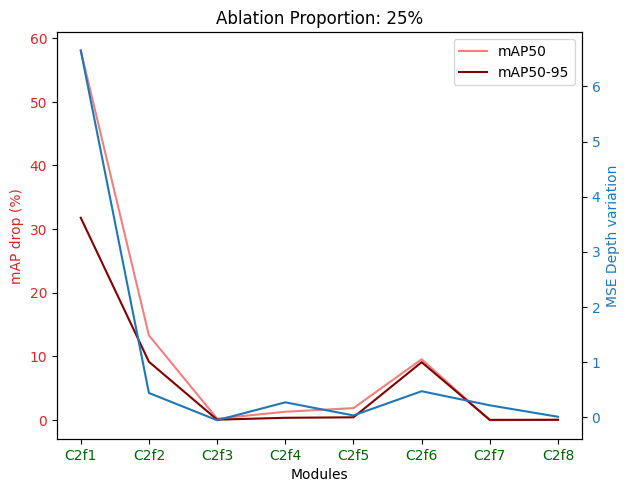

In [10]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Modules')
ax1.set_ylabel('mAP drop (%)', color=color)
ax1.plot(c2f_map50_diff_25, color='lightcoral')
ax1.plot(c2f_map5095_diff_25, color='maroon')
ax1.legend(['mAP50', 'mAP50-95'], loc='upper right')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', labelcolor='darkgreen')

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('MSE Depth variation', color=color) 
ax2.plot(c2f_mseDepth_diff_25, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Ablation Proportion: 25%')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], c2f_labels)
plt.savefig('cf2_25.png', bbox_inches='tight')
plt.show()

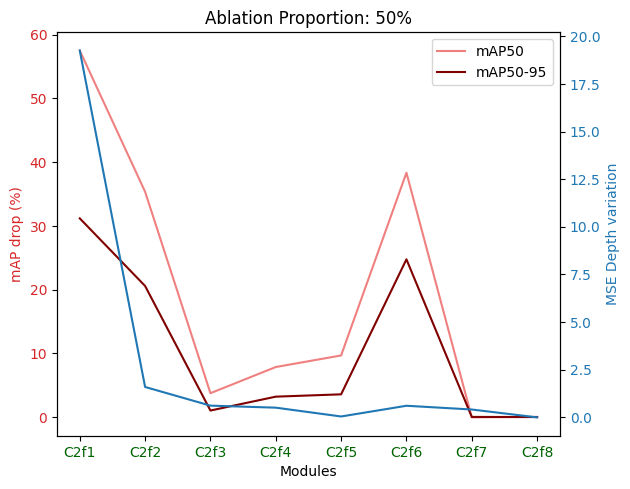

In [11]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Modules')
ax1.set_ylabel('mAP drop (%)', color=color)
ax1.plot(c2f_map50_diff_50, color='lightcoral')
ax1.plot(c2f_map5095_diff_50, color='maroon')
ax1.legend(['mAP50', 'mAP50-95'], loc='upper right')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', labelcolor='darkgreen')

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('MSE Depth variation', color=color) 
ax2.plot(c2f_mseDepth_diff_50, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Ablation Proportion: 50%')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], c2f_labels)
plt.savefig('cf2_50.png', bbox_inches='tight')
plt.show()

### Detect

In [12]:
detect_labels = ['Detect1','Detect2','Detect3']

detect_map50_diff_10 = []
detect_map50_diff_25 = []
detect_map50_diff_50 = []

detect_map5095_diff_10 = []
detect_map5095_diff_25 = []
detect_map5095_diff_50 = []

detect_mseDepth_diff_10 = []
detect_mseDepth_diff_25 = []
detect_mseDepth_diff_50 = []

for detect in detect_modules:
    
    # mAP50
    diff = baseline['mAP50'] - detect['10']['mAP50']
    detect_map50_diff_10.append(diff*100)
    
    diff = baseline['mAP50'] - detect['25']['mAP50']
    detect_map50_diff_25.append(diff*100)
    
    diff = baseline['mAP50'] - detect['50']['mAP50']
    detect_map50_diff_50.append(diff*100)

    
    # mAP50-95
    diff = baseline['mAP50-95'] - detect['10']['mAP50-95']
    detect_map5095_diff_10.append(diff*100)
    
    diff = baseline['mAP50-95'] - detect['25']['mAP50-95']
    detect_map5095_diff_25.append(diff*100)
    
    diff = baseline['mAP50-95'] - detect['50']['mAP50-95']
    detect_map5095_diff_50.append(diff*100)
    
    # depth
    diff = baseline['depth'] - detect['10']['depth']
    detect_mseDepth_diff_10.append(-diff)
    
    diff = baseline['depth'] - detect['25']['depth']
    detect_mseDepth_diff_25.append(-diff)
    
    diff = baseline['depth'] - detect['50']['depth']
    detect_mseDepth_diff_50.append(-diff)    
    

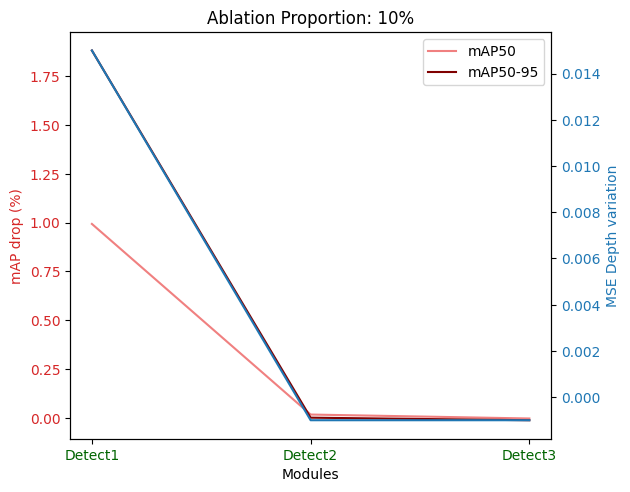

In [13]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Modules')
ax1.set_ylabel('mAP drop (%)', color=color)
ax1.plot(detect_map50_diff_10, color='lightcoral')
ax1.plot(detect_map5095_diff_10, color='maroon')
ax1.legend(['mAP50', 'mAP50-95'], loc='upper right')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', labelcolor='darkgreen')

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('MSE Depth variation', color=color) 
ax2.plot(detect_mseDepth_diff_10, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Ablation Proportion: 10%')
plt.xticks([0, 1, 2], detect_labels)
plt.savefig('detect_10.png', bbox_inches='tight')
plt.show()

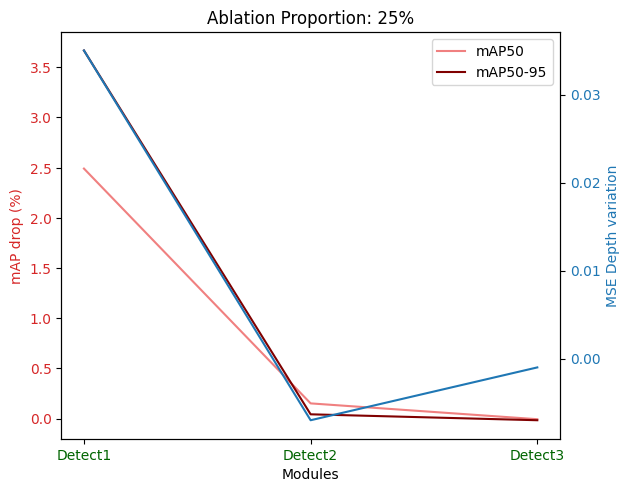

In [14]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Modules')
ax1.set_ylabel('mAP drop (%)', color=color)
ax1.plot(detect_map50_diff_25, color='lightcoral')
ax1.plot(detect_map5095_diff_25, color='maroon')
ax1.legend(['mAP50', 'mAP50-95'], loc='upper right')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', labelcolor='darkgreen')

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('MSE Depth variation', color=color) 
ax2.plot(detect_mseDepth_diff_25, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Ablation Proportion: 25%')
plt.xticks([0, 1, 2], detect_labels)
plt.savefig('detect_25.png', bbox_inches='tight')
plt.show()

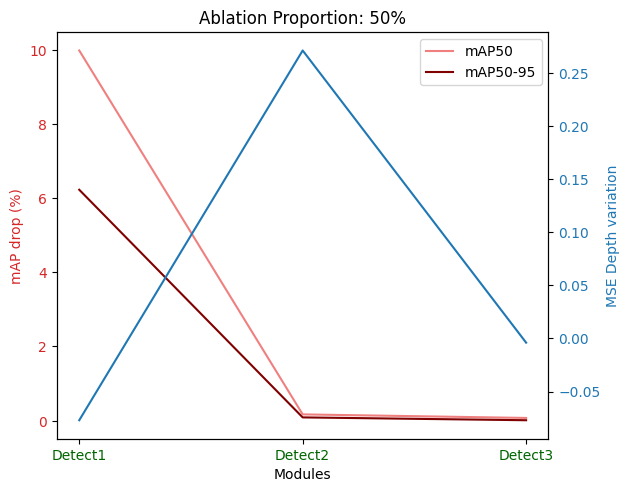

In [15]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Modules')
ax1.set_ylabel('mAP drop (%)', color=color)
ax1.plot(detect_map50_diff_50, color='lightcoral')
ax1.plot(detect_map5095_diff_50, color='maroon')
ax1.legend(['mAP50', 'mAP50-95'], loc='upper right')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', labelcolor='darkgreen')

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('MSE Depth variation', color=color) 
ax2.plot(detect_mseDepth_diff_50, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Ablation Proportion: 50%')
plt.xticks([0, 1, 2], detect_labels)
plt.savefig('detect_50.png', bbox_inches='tight')
plt.show()